In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from IPython.display import Image

In [2]:
data_csv = pd.read_csv(r'C:\Users\rjhcl\Downloads\ships image classification\train\train.csv')
print('data shape: ', data_csv.shape)

categories = {0: 'Cargo' , 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tankers'}

data_csv['category'] = data_csv['category'] - 1
data_csv['label'] = data_csv['category'].map(categories)
data_csv['label'] = pd.Categorical(data_csv['label'])
data_csv.head()

data shape:  (6252, 2)


,image,category,label
0,2823080.jpg,0,Cargo
1,2870024.jpg,0,Cargo
2,2662125.jpg,1,Military
3,2900420.jpg,2,Carrier
4,2804883.jpg,1,Military


C:\Users\rjhcl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Counts of observation')

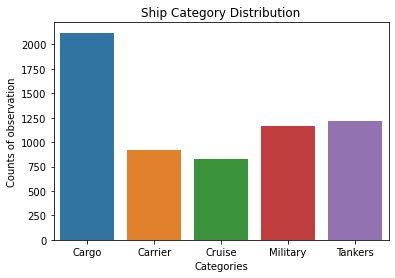

In [3]:
sns.countplot(data_csv['label'])
plt.title('Ship Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Counts of observation')

In [5]:
import cv2

path = r'C:\Users\rjhcl\Downloads\ships image classification\train\images'

img_list = list(data_csv['image'])

data_img = []

for each in img_list:
    each_path = os.path.join(path,each)
    each_img = cv2.imread(each_path)
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    each_img_resized = cv2.resize(each_img, (128,128))
    data_img.append(each_img_resized)
    
X = np.array(data_img)
print('Shape of X: ', X.shape)

Shape of X:  (6252, 128, 128, 3)


In [6]:
from sklearn.preprocessing import OneHotEncoder

y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(data_csv['category'].values.reshape(-1,1))
print('Shape of y: ', y.shape)

Shape of y:  (6252, 5)


In [7]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(X,y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2, random_state=42)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip= True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5
                              )
validation_gen = ImageDataGenerator(horizontal_flip= True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5
                              )

train_gen.fit(X_train)
validation_gen.fit(X_val)

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

batch_size = 100
epochs = 15

base = Xception(include_top = False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)

head = Dense(5, activation = 'softmax')(x)
model = Model(inputs = base.input, outputs = head)

model.compile(optimizer=Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
             )

history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size = batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size = batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size
                             )

<ipython-input-16-3bd32a636d6b>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size = batch_size),


Epoch 1/15
42/42 [==============================] - 983s 23s/step - loss: 1.3304 - accuracy: 0.4654 - val_loss: 1.6035 - val_accuracy: 0.4384
Epoch 2/15
42/42 [==============================] - 4064s 99s/step - loss: 0.7940 - accuracy: 0.6909 - val_loss: 1.1540 - val_accuracy: 0.6246
Epoch 3/15
42/42 [==============================] - 613s 15s/step - loss: 0.5962 - accuracy: 0.7697 - val_loss: 0.8761 - val_accuracy: 0.7234
Epoch 4/15
42/42 [==============================] - 11468s 279s/step - loss: 0.5072 - accuracy: 0.7938 - val_loss: 0.6556 - val_accuracy: 0.7676
Epoch 5/15
42/42 [==============================] - 562s 13s/step - loss: 0.4575 - accuracy: 0.8261 - val_loss: 0.5467 - val_accuracy: 0.8006
Epoch 6/15
42/42 [==============================] - 11444s 279s/step - loss: 0.4307 - accuracy: 0.8379 - val_loss: 0.5156 - val_accuracy: 0.8034
Epoch 7/15
42/42 [==============================] - 533s 13s/step - loss: 0.3902 - accuracy: 0.8470 - val_loss: 0.4684 - val_accuracy: 0.8175

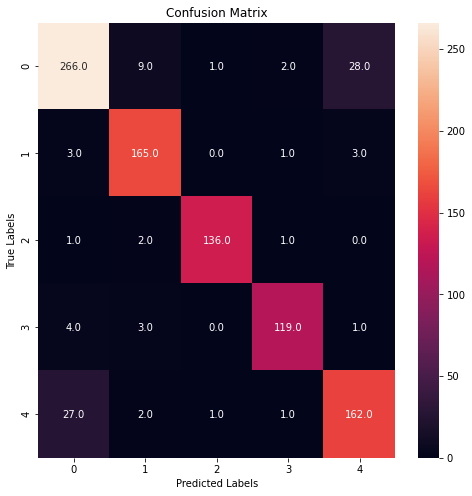

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt = '.1f', ax=ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       306
           1       0.91      0.96      0.93       172
           2       0.99      0.97      0.98       140
           3       0.96      0.94      0.95       127
           4       0.84      0.84      0.84       193

    accuracy                           0.90       938
   macro avg       0.92      0.92      0.92       938
weighted avg       0.90      0.90      0.90       938



In [21]:
model.save("Ship-shape.h5")

C:\Users\rjhcl\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [26]:
%%writefile my_app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
st.title("Image Classification")
upload_file = st.sidebar.file_uploader("Upload ship images", type = 'jpg')
generate_pred = st.sidebar.button("predict")
model = tf.keras.models.load_model('Ship-shape.h5')
def import_n_pred(image_data, model):
    size = (128,128)
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    img = np.asarray(image)
    reshape = img[np.newaxis,...]
    pred = model.predict(reshape)
    return pred
if generate_pred:
    image = Image.open(upload_file)
    with st.beta_expander('image', expanded=True):
        st.image(image, use_column_width=True)
    pred = import_n_pred(image, model)
    labels = ['Cargo ship' , 'Military ship', 'Carrier ship', 'Cruise', 'Tanker ship']
    st.title("prediction of image is {}".format(labels[np.argmax(pred)]))

Overwriting my_app.py


In [ ]:
!streamlit run my_app.py